In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams.update({'font.size': 14})

Default elec/sterics protocol

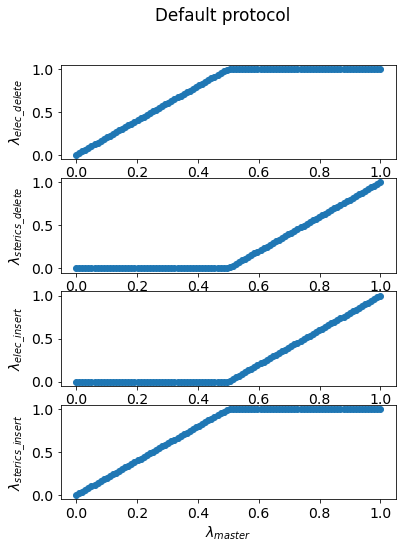

In [7]:
fig, axs = plt.subplots(4, figsize=(6, 8))
fig.suptitle('Default protocol')

x = np.linspace(0.,1.,100)
inflection = 0.5

y = [1 if i > inflection else 2*i for i in x] # 
axs[0].scatter(x, y, label='elec_delete')

y = [2*(i-inflection) if i > inflection else 0 for i in x]
axs[1].scatter(x, y, label='sterics_delete')

y = [2*(i-inflection) if i > inflection else 0 for i in x]
axs[2].scatter(x, y, label='elec_insert')

y = [1 if i > inflection else 2*i for i in x]
axs[3].scatter(x, y, label='sterics_insert')

for i, label in enumerate([r'$\lambda_{elec\_delete}$', r'$\lambda_{sterics\_delete}$', r'$\lambda_{elec\_insert}$', r'$\lambda_{sterics\_insert}$']):
    plt.setp(axs[i], ylabel=label)

plt.xlabel(r'$\lambda_{master}$')
plt.show()

Multi-phase protocol

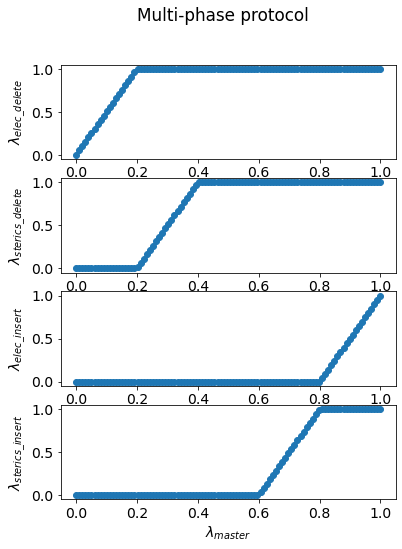

In [8]:
fig, axs = plt.subplots(4, figsize=(6, 8))
fig.suptitle('Multi-phase protocol')

x = np.linspace(0.,1.,100)
inflection1, inflection2, inflection3, inflection4 = 0.2, 0.4, 0.6, 0.8

y = [(1/inflection1)*i if i < inflection1 else 1  for i in x] # 
axs[0].scatter(x, y, label='elec_delete')

y = [0 if i < inflection1 else ((1/inflection1)*(i-inflection1) if i < inflection2 else 1) for i in x]
axs[1].scatter(x, y, label='sterics_delete')

y = [0 if i < inflection4 else (1/inflection1)*(i-inflection4) for i in x]
axs[2].scatter(x, y, label='elec_insert')

y = [0 if i < inflection3 else ((1/inflection1)*(i-inflection3) if i < inflection4 else 1) for i in x]
axs[3].scatter(x, y, label='sterics_insert')

for i, label in enumerate([r'$\lambda_{elec\_delete}$', r'$\lambda_{sterics\_delete}$', r'$\lambda_{elec\_insert}$', r'$\lambda_{sterics\_insert}$']):
    plt.setp(axs[i], ylabel=label)
#     plt.setp(axs[i].get_ylabel(), fontsize=20)

plt.xlabel(r'$\lambda_{master}$')
plt.show()

## Test lepton implementation

In [4]:
import logging
import pickle
import numpy as np
from openmmtools.integrators import PeriodicNonequilibriumIntegrator
from simtk import unit, openmm
import argparse
import os
import time
import mdtraj as md
from tqdm import tqdm_notebook
from openmmtools.constants import kB

from openmmtools.states import ThermodynamicState, CompoundThermodynamicState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)



In [7]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/14/76/"
phase = 'apo'
sim_number = 1
old_aa_name = 'asn'
new_aa_name = 'lys'
length = 1
cache = 1
cache_length = 1

In [8]:
# Define lambda functions
x = 'lambda'
inflection1, inflection2, inflection3, inflection4 = 0.2, 0.4, 0.6, 0.8
DEFAULT_ALCHEMICAL_FUNCTIONS = {
                             'lambda_sterics_core': x,
                             'lambda_electrostatics_core': x,
                             'lambda_sterics_insert': f"select(step({x} - {inflection3}), select(step({x}-{inflection4}), 1, (1/{inflection1})*({x}-{inflection3}), 0.0)",
                             'lambda_sterics_delete': f"select(step({x} - {inflection1}), select(step({x} - {inflection2}), 1, (1/{inflection1})*({x}-{inflection1})), 0.0)",
                             'lambda_electrostatics_insert': f"select(step({x} - {inflection4}), (1/{inflection1}) * ({x} - {inflection4}), 0.0)",
                             'lambda_electrostatics_delete': f"select(step({x} - {inflection1}), 1.0, (1/{inflection1})*{x})",
                             'lambda_bonds': x,
                             'lambda_angles': x,
                             'lambda_torsions': x}

# Define simulation parameters
# nsteps_eq = 25000 # 100 ps 
nsteps_eq = 1
nsteps_neq = 250000
neq_splitting='V R H O R V'
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'
cache_length = 1
temperature = 298.0 * unit.kelvin
kT = kB * temperature


In [9]:
# Read in vanilla htf
i = os.path.basename(os.path.dirname(outdir))
with open(os.path.join("/data/chodera/zhangi/perses_benchmark/neq/15/76/", f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)




In [10]:
# Read in lambda = 0 cache
with open(os.path.join(outdir, f"{i}_{phase}_{old_aa_name}_{cache_length}ns_snapshots.npy"), 'rb') as f:
    subset_pos = np.load(f)
positions = subset_pos[sim_number]
system = htf.hybrid_system


In [11]:
# Read in lambda = 0 cache box vectors
with open(os.path.join(outdir, f"box_vectors.npy"), 'rb') as f:
    subset_box_vectors = np.load(f)
box_vectors = subset_box_vectors[sim_number][0]


In [5]:
inflection1, inflection2, inflection3, inflection4 = 0.2, 0.4, 0.6, 0.8

multiphase = {'lambda_sterics_core':
                         lambda x: x,
                         'lambda_electrostatics_core':
                         lambda x: x,
                         'lambda_sterics_insert':
                         lambda x: 0.0 if x < inflection3 else ((1.0/inflection1)*(x-inflection3) if x < inflection4 else 1.0),
                         'lambda_sterics_delete':
                         lambda x: 0.0 if x < inflection1 else ((1.0/inflection1)*(x-inflection1) if x < inflection2 else 1.0),
                         'lambda_electrostatics_insert':
                         lambda x: 0.0 if x < inflection4 else (1.0/inflection1)*(round(x-inflection4, 2)),
                         'lambda_electrostatics_delete':
                         lambda x: (1.0/inflection1)*x if x < inflection1 else 1.0,
                         'lambda_bonds':
                         lambda x: x,
                         'lambda_angles':
                         lambda x: x,
                         'lambda_torsions':
                         lambda x: x
                         }

In [28]:
# # Create CompoundThermodynamicState at the appropriate endstate 
lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
lambda_protocol = LambdaProtocol(functions=multiphase)
# lambda_protocol = LambdaProtocol(functions="default")

lambda_alchemical_state.set_alchemical_parameters(0.7, lambda_protocol)
thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])


In [22]:
thermodynamic_state.lambda_electrostatics_insert

0.3999999999999999

In [29]:
# Set up integrator
integrator = PeriodicNonequilibriumIntegrator(DEFAULT_ALCHEMICAL_FUNCTIONS, nsteps_eq, nsteps_neq, neq_splitting, timestep=timestep, temperature=temperature)

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')
# context = openmm.Context(system, integrator, platform)
context = thermodynamic_state.create_context(integrator, platform=platform)
context.setPeriodicBoxVectors(*box_vectors)
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)


In [30]:
for name in list(context.getParameters())[2:-1]:
    print(name, context.getParameter(name))

lambda_angles 0.7
lambda_bonds 0.7
lambda_electrostatics_core 0.7
lambda_electrostatics_delete 1.0
lambda_electrostatics_insert 0.0
lambda_sterics_core 0.7
lambda_sterics_delete 1.0
lambda_sterics_insert 0.4999999999999999
lambda_torsions 0.7


## Get lambdas and plot

In [12]:
lambdas = []
for i in tqdm_notebook(np.linspace(0.,1.,20)):
    print(f"lambda: {i}")
    
    lambda_dict = {}
    
    # Create CompoundThermodynamicState at the appropriate endstate 
    lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
    lambda_protocol = LambdaProtocol(functions=multiphase)
    # lambda_protocol = LambdaProtocol(functions="default")

    lambda_alchemical_state.set_alchemical_parameters(i, lambda_protocol)
    thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])

    # Set up integrator
    integrator = PeriodicNonequilibriumIntegrator(DEFAULT_ALCHEMICAL_FUNCTIONS, nsteps_eq, nsteps_neq, neq_splitting, timestep=timestep, temperature=temperature)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
    context = thermodynamic_state.create_context(integrator, platform=platform)
    context.setPeriodicBoxVectors(*box_vectors)
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    
    # Get parameter
    for name in list(context.getParameters())[2:-1]:
        print(name, context.getParameter(name))
        lambda_dict[name] = context.getParameter(name)
    
    lambdas.append(lambda_dict)


<ipython-input-12-50082ebf5b21>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.linspace(0.,1.,20)):


  0%|          | 0/20 [00:00<?, ?it/s]

lambda: 0.0
lambda_angles 0.0
lambda_bonds 0.0
lambda_electrostatics_core 0.0
lambda_electrostatics_delete 0.0
lambda_electrostatics_insert 0.0
lambda_sterics_core 0.0
lambda_sterics_delete 0.0
lambda_sterics_insert 0.0
lambda_torsions 0.0
lambda: 0.05263157894736842
lambda_angles 0.05263157894736842
lambda_bonds 0.05263157894736842
lambda_electrostatics_core 0.05263157894736842
lambda_electrostatics_delete 0.2631578947368421
lambda_electrostatics_insert 0.0
lambda_sterics_core 0.05263157894736842
lambda_sterics_delete 0.0
lambda_sterics_insert 0.0
lambda_torsions 0.05263157894736842
lambda: 0.10526315789473684
lambda_angles 0.10526315789473684
lambda_bonds 0.10526315789473684
lambda_electrostatics_core 0.10526315789473684
lambda_electrostatics_delete 0.5263157894736842
lambda_electrostatics_insert 0.0
lambda_sterics_core 0.10526315789473684
lambda_sterics_delete 0.0
lambda_sterics_insert 0.0
lambda_torsions 0.10526315789473684
lambda: 0.15789473684210525
lambda_angles 0.15789473684210

In [19]:
for lambda_dict in lambdas:
    print(lambda_dict['lambda_electrostatics_insert'])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.44999999999999996
0.75
1.0


In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
plt.rcParams.update({'font.size': 14})

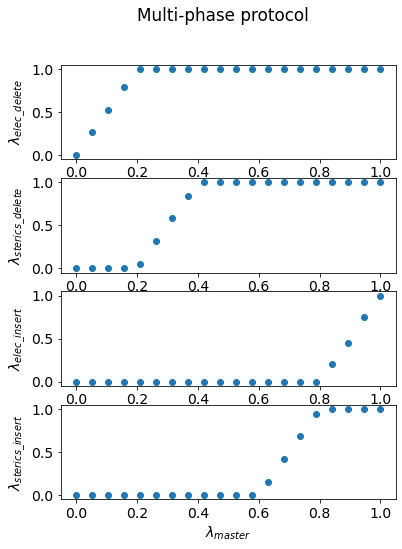

In [12]:
fig, axs = plt.subplots(4, figsize=(6, 8))
fig.suptitle('Multi-phase protocol')

x = np.linspace(0.,1.,20)

y = [lambda_dict['lambda_electrostatics_delete'] for lambda_dict in lambdas]
axs[0].scatter(x, y, label='elec_delete')

y = [lambda_dict['lambda_sterics_delete'] for lambda_dict in lambdas]
axs[1].scatter(x, y, label='sterics_delete')

y = [lambda_dict['lambda_electrostatics_insert'] for lambda_dict in lambdas]
axs[2].scatter(x, y, label='elec_insert')

y = [lambda_dict['lambda_sterics_insert'] for lambda_dict in lambdas]
axs[3].scatter(x, y, label='sterics_insert')

for i, label in enumerate([r'$\lambda_{elec\_delete}$', r'$\lambda_{sterics\_delete}$', r'$\lambda_{elec\_insert}$', r'$\lambda_{sterics\_insert}$']):
    plt.setp(axs[i], ylabel=label)

plt.xlabel(r'$\lambda_{master}$')
plt.show()